# **Klasifikasi Time Series Sensor Mesin FordA Menggunakan Model Support Vector Machine (SVM)**

## **Business Understanding**

Sistem sensor kendaraan menghasilkan data sinyal kontinu (time-series) yang menggambarkan kondisi operasional mesin. Klasifikasi sinyal ini membantu mendeteksi kondisi abnormal lebih awal sehingga maintenance bisa dilakukan lebih cepat.

Dataset FordA adalah dataset sensor mesin (automotive) yang umum digunakan untuk time series classification (normal vs abnormal).

Tujuannya adalah mengklasifikasikan sinyal FordA menjadi normal/abnormal

## **Data Understanding**

### **Load Data**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

TRAIN_PATH = "FordA_TRAIN.txt"
TEST_PATH  = "FordA_TEST.txt"

def load_forda(path):
    # file: kolom 0 = label, kolom 1..N = time series
    df = pd.read_csv(path, sep=r"\s+", header=None)
    y = df.iloc[:, 0]
    X = df.iloc[:, 1:]
    return X, y, df

X_train, y_train, df_train = load_forda(TRAIN_PATH)
X_test,  y_test,  df_test  = load_forda(TEST_PATH)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)
print("Jumlah fitur (panjang time series):", X_train.shape[1])


Shape X_train: (3601, 500)
Shape X_test : (1320, 500)
Jumlah fitur (panjang time series): 500


#### Tampilan Data

In [4]:
print("=== 5 baris pertama TRAIN (label + sebagian fitur) ===")
display(df_train.iloc[:5, :10])  # 1 label + 9 fitur pertama

print("\n=== Info TRAIN ===")
print(df_train.info())


=== 5 baris pertama TRAIN (label + sebagian fitur) ===


,0,1,2,3,4,5,6,7,8,9
0,-1.0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251
1,1.0,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192
2,-1.0,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751



=== Info TRAIN ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, 0 to 500
dtypes: float64(501)
memory usage: 13.8 MB
None


Terdapat total 4721 baris dan 500 fitur

### **Distribusi Kelas**

Distribusi kelas TRAIN:
0
-1.0    1846
 1.0    1755
Name: count, dtype: int64

Distribusi kelas TEST:
0
-1.0    681
 1.0    639
Name: count, dtype: int64


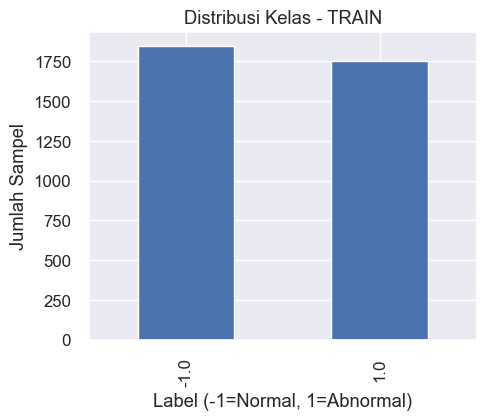

In [5]:
print("Distribusi kelas TRAIN:")
print(y_train.value_counts().sort_index())

print("\nDistribusi kelas TEST:")
print(y_test.value_counts().sort_index())

plt.figure(figsize=(5,4))
y_train.value_counts().sort_index().plot(kind="bar")
plt.title("Distribusi Kelas - TRAIN")
plt.xlabel("Label (-1=Normal, 1=Abnormal)")
plt.ylabel("Jumlah Sampel")
plt.show()


### **Cek Missing Value**

In [6]:
print("Total missing value TRAIN:", X_train.isna().sum().sum())
print("Total missing value TEST :", X_test.isna().sum().sum())

# Jika ingin lihat kolom yang punya missing (kalau ada)
missing_cols_train = X_train.columns[X_train.isna().any()]
print("Kolom dengan missing (TRAIN):", missing_cols_train.tolist())

# cek missing di test set
missing_cols_test = X_test.columns[X_test.isna().any()]
print("Kolom dengan missing (TEST):", missing_cols_test.tolist())


Total missing value TRAIN: 0
Total missing value TEST : 0
Kolom dengan missing (TRAIN): []
Kolom dengan missing (TEST): []


### **Cek Duplikasi Data**

In [7]:
dup_full_train = df_train.duplicated().sum()
dup_X_train    = X_train.duplicated().sum()

print("Jumlah baris duplikat (TRAIN, termasuk label):", dup_full_train)
print("Jumlah baris duplikat (TRAIN, fitur saja):", dup_X_train)


Jumlah baris duplikat (TRAIN, termasuk label): 0
Jumlah baris duplikat (TRAIN, fitur saja): 0


### **Deteksi Outlier**

In [8]:
from scipy.stats import zscore

# hitung z-score per fitur (axis=1 → normalisasi per baris)
z = np.abs(zscore(X_train, axis=1, nan_policy='omit'))

THRESH = 3
outlier_rows = np.where(z > THRESH)[0]
outlier_rows_unique = np.unique(outlier_rows)

print("Jumlah sampel TRAIN yang mengandung outlier (|z|>3):", len(outlier_rows_unique))

# tampilkan 5 sampel pertama yang terdeteksi outlier (label + beberapa fitur awal)
outlier_samples = df_train.iloc[outlier_rows_unique[:5], :10]
print("\nContoh 5 sampel outlier (label + 9 fitur pertama):")
display(outlier_samples)


Jumlah sampel TRAIN yang mengandung outlier (|z|>3): 1135

Contoh 5 sampel outlier (label + 9 fitur pertama):


,0,1,2,3,4,5,6,7,8,9
3,-1.0,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430
4,-1.0,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751
8,1.0,0.825565,0.385282,-0.062416,-0.480982,-0.831189,-1.081840,-1.213596,-1.231525,-1.141304
10,1.0,0.529562,0.695556,0.754557,0.688517,0.549053,0.391765,0.259718,0.210681,0.271933
14,1.0,1.429452,1.079359,0.510714,-0.146231,-0.738000,-1.176298,-1.362886,-1.273359,-0.967208


### **Visualisasi Time Series per Kelas**

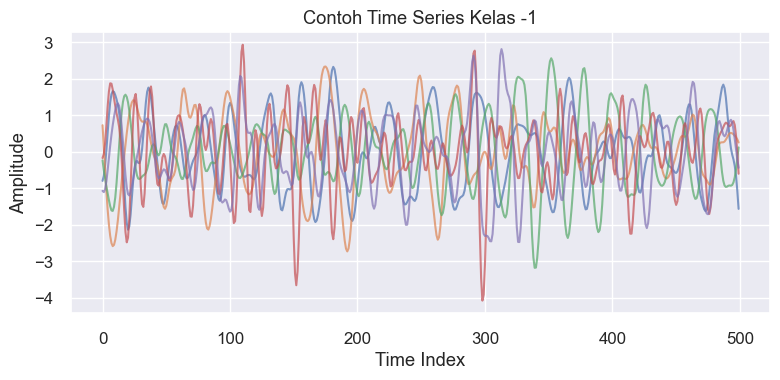

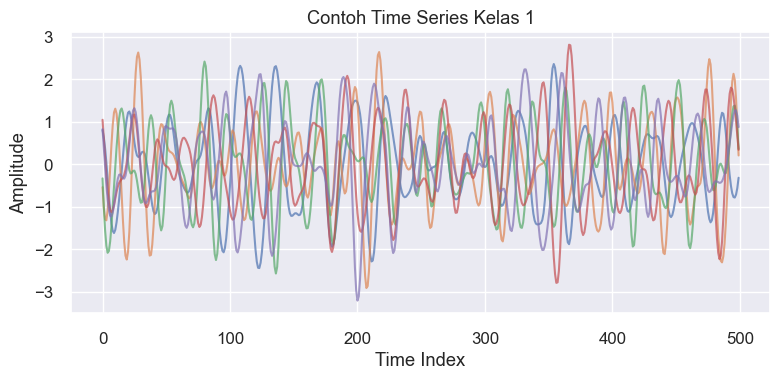

In [9]:
n_timestamps = X_train.shape[1]
time_axis = np.arange(n_timestamps)

def plot_sample_series(X, y, label_value, n_samples=5):
    idx = np.where(y == label_value)[0][:n_samples]
    plt.figure(figsize=(8,4))
    for i in idx:
        plt.plot(time_axis, X.iloc[i, :], alpha=0.7)
    plt.title(f"Contoh Time Series Kelas {label_value}")
    plt.xlabel("Time Index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

plot_sample_series(X_train, y_train, -1, n_samples=5)
plot_sample_series(X_train, y_train,  1, n_samples=5)


## **Prepocessing**

### **Train–Validation Split (numerik)**

In [10]:
from sklearn.model_selection import train_test_split

X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

X_train_split.shape, X_valid_split.shape


((2880, 500), (721, 500))

### **SVM – Pipeline (Imputer + Scaler + SVM)**

DIlakukan pipeline agar urut setelah dilakukan imputasi, maka ke scaling dulu (scaling data ke distribusi normal) karena svm sensitif terhadap skala data kemudian dilakukan modeling

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=10, gamma="scale", probability=True))
])


## **Modeling**

Modeling akan menggunakan Support Vector Machine, karena terdapat paper rujukan: https://www.nature.com/articles/s41598-025-25667-0

yang mengatakan bahwa:

SVM ternyata:

* cepat

* akurat

* cocok untuk FordA

### **SVM**

Setelah dilakukan pipeline agar proses lebih rapi, langsung lakukan training

In [15]:
svm_pipeline.fit(X_train_split, y_train_split)
print("Training SVM selesai.")


Training SVM selesai.


Simpan model SVM

In [ ]:
import joblib
joblib.dump(svm_pipeline, "svm_forda_pipeline.pkl")


## **Evaluasi**

### **Evaluasi SVM**

Didapatkan akurasi sebagai berikut:
SVM Test Accuracy: 0.8159090909090909
Classification Report (SVM):

              precision    recall  f1-score   support

        -1.0       0.82      0.83      0.82       681
         1.0       0.82      0.80      0.81       639

    accuracy                           0.82      1320
   macro avg       0.82      0.82      0.82      1320
weighted avg       0.82      0.82      0.82      1320



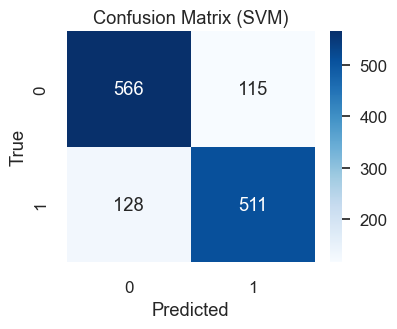

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# prediction
y_pred_svm = svm_pipeline.predict(X_test)

# accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)
print("Didapatkan akurasi sebagai berikut:")
print("SVM Test Accuracy:", acc_svm)

# classification report
print("Classification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm))

# confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(4,3))
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## **Deployment**

Setelah selesai semua, buat struktur file seperti ini:

- app.py
- svm_forda_pipeline.pkl (dari proses simpam modeling tadi)
- requirements.txt

Anda dapat melihat lengkapnya di github: https://github.com/yudhacm/ford-a-classification

Setelah itu push ke github semua file tersebut dan menuju ke streamlit. Ambil repo yang sudah dibuat dan deploy

Hasil deploy: https://uas-psd-230411100057.streamlit.app/

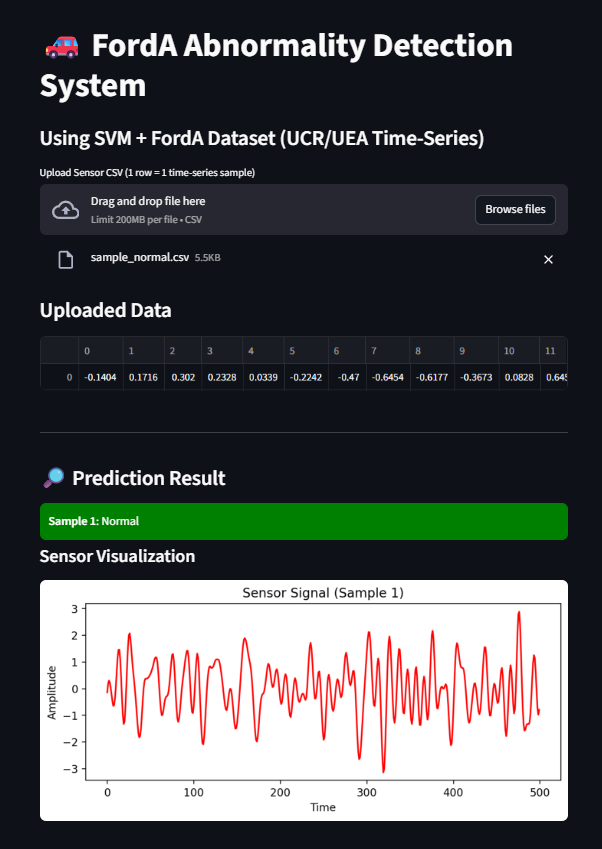